In [1]:
import glob
import pandas as pd
import os

%matplotlib inline

In [2]:
def feature_counts(directory):
    fn = directory+ '/feature_names.txt'
    with open(fn) as f:
        lines = f.readlines()
        keep = int(lines[1].split('\t')[1])
        remove = int(lines[2].split('\t')[1])
    return keep, remove

In [3]:
def load_majority_vote(exp_path):
    fn = exp_path+'/majority_vote.csv'
    res = pd.read_csv(fn)
    return res

def load_roadnet(exp_path):
    fselects = ['None']
    res = []
    for selection_type in fselects:
        exp_param_path = '%s/%s#%s' %(exp_path, 'RoadNet', selection_type)
        fn = '%s/cv_5_best_models_evaluation.csv' %(exp_param_path)
        cv_res = pd.read_csv(fn)
        cv_res.columns = ['kind', 'model'] + cv_res.columns[2:].tolist()
        cv_res['feature_select'] = selection_type
        cv_res['scale'] = 'min-max'
        cv_res['feature'] = 'RoadNet'
        keep, remove = feature_counts(exp_param_path)
        cv_res['# ftr keep'] = keep
        cv_res['# ftr remove'] = remove
        res.append(cv_res)
    res = pd.concat(res)
    return res 

def load_else(exp_path):
    
    totals = ['NO_TOTAL', 'TOTAL']
    years_choices = ['~2014']
    feature_types = ['Segment', 'RoadNet+Segment']
    res = []
    for total_or_not in totals:
        for year in years_choices:
            for ftr_type in feature_types:
                for max_cut in ( False,):
                    for selection_type in ['None']:
                        scale_type = 'max-cutoff' if max_cut else 'min-max'
                        exp_param = '#'.join([ftr_type, total_or_not, year, scale_type, selection_type])
                        fn = '%s/%s/cv_5_best_models_evaluation.csv' % (exp_path, exp_param)
                        cv_res = pd.read_csv(fn)
                        cv_res.columns = ['kind', 'model'] + cv_res.columns[2:].tolist()
                        cv_res['feature_select'] = selection_type
                        cv_res['scale'] = scale_type
                        cv_res['feature'] = ftr_type
                        cv_res['time period'] = year
                        cv_res['total or by type'] = total_or_not
                        keep, remove = feature_counts('%s/%s' % (exp_path, exp_param))
                        cv_res['# ftr keep'] = keep
                        cv_res['# ftr remove'] = remove
                        res.append(cv_res)
    res = pd.concat(res)

    return res 

def load_one_run(seed):
    exp_path = 'experiment_1001/exp1/seed_%d' % seed
    major = load_majority_vote(exp_path)
    roadnet = load_roadnet(exp_path)
    res_else = load_else(exp_path)
    res = pd.concat([major, roadnet, res_else], ignore_index=True)
    res['seed'] = seed
    return res

In [4]:
def load_all_run():
    all_run = []
    for seed in [0, 100, 972, 5258, 7821, 40918, 57852, 168352, 291592, 789729423]:
        one_run_res = load_one_run(seed)
        all_run.append(one_run_res)
    all_run_res = pd.concat(all_run, ignore_index=True)
    all_run_res.fillna('', inplace=True)
    all_run_res['key'] = all_run_res.apply(lambda x: '%s %s %s %s %s %s'.strip() % (x['feature'], x['total or by type'], x['time period'], x['model'], x['scale'], x['feature_select']), axis=1)        
#     all_run_res['key'] = all_run_res.apply(lambda x: '%s %s %s %s'.strip() % (x['feature'], x['total or by type'], x['model'], x['scale']), axis=1)        
    return all_run_res

In [5]:
all_run_res = load_all_run()

In [6]:
all_run_res['col_name'] = all_run_res.apply(lambda x: x['feature']+' '+x['total or by type'],axis=1)

# slice res by feature selection, time period and scale method

In [7]:
cond1 = (all_run_res['feature_select'] == 'None') | (all_run_res['feature_select'] == '')
cond2 = (all_run_res['time period']=='~2014') | (all_run_res['time period'] == '')
cond3 = (all_run_res['scale']=='min-max')  | (all_run_res['scale'] == '')
slice_res = all_run_res[(cond1) & (cond2) & (cond3) ]

In [8]:
slice_res.shape

(1110, 22)

Drop useless columns

In [35]:
col_mapping = {' ': ' ',
 'RoadNet ': 'RoadNet',
 'Segment NO_TOTAL': 'Social type', 
 'RoadNet+Segment NO_TOTAL': 'RoadNet+Social type',
 'Segment TOTAL': 'Social total', 
 'RoadNet+Segment TOTAL': 'RoadNet+Social total'}


In [36]:
clean_res = slice_res.drop(['feature', 'total or by type', 'time period', 'scale', 'feature_select',
                  'kind', '# ftr remove', '# ftr keep', 
                  'train_acc', 'train_f1_macro', 'train_f1_micro', 'train_f1_weighted', 'train_mse',
                  'test_acc', 'test_mse',
                  'seed',
                  'key',
                 ], axis=1)
clean_res.col_name = clean_res.col_name.apply(lambda x: col_mapping[x])

In [37]:
means = clean_res.groupby(['col_name', 'model']).mean()
stds = clean_res.groupby(['col_name', 'model']).std()

## produce dtb(deliverable table) for paper

In [38]:
def deliverable_table(table):
    table.loc['majority_vote'] = table.loc['majority_vote', ' ']
    table.drop(' ', axis=1, inplace=True)
#     table.columns = ['RoadNet', 'RoadNet+Social type', 'RoadNet+Social total', 'Social type', 'Social total']
    table = table[['RoadNet', 'Social total', 'Social type', 'RoadNet+Social total', 'RoadNet+Social type']]
    table = table.loc[['majority_vote', 'ols', 'lasso', 'ridge', 'logistics', 'linearSVM', 'linearSVR',
               'SVM', 'SVR', 'MLPcls', 'MLPreg', 'DTcls', 'DTreg', 'RFcls', 'RFreg',
               'ADAcls', 'ADAreg', 'BAGcls', 'BAGreg', 'GDBcls', 'GDBreg', 'XGBcls', 'XGBreg',
          ]]
    return table

In [39]:
f1_choices = ['test_f1_weighted', 'test_f1_macro', 'test_f1_micro']
f1_type = f1_choices[0]
table = means.reset_index().pivot(index='model', columns='col_name', values=f1_type)

dtb = deliverable_table(table)
dtb.to_csv('deliverables/experiment_1001/EXP1 %s.csv' % f1_type)
dtb


col_name,RoadNet,Social total,Social type,RoadNet+Social total,RoadNet+Social type
model,,,,,
majority_vote,0.286859,0.286859,0.286859,0.286859,0.286859
ols,0.537224,0.401091,0.449637,0.593512,0.420300
lasso,0.286859,0.286859,0.286859,0.286859,0.286859
ridge,0.524819,0.316935,0.464028,0.551342,0.565960
logistics,0.558133,0.488198,0.499182,0.580082,0.564957
linearSVM,0.550980,0.482630,0.521679,0.556236,0.565323
linearSVR,0.518166,0.364968,0.435283,0.524820,0.546088
SVM,0.619953,0.462727,0.476988,0.604980,0.557175
SVR,0.541658,0.352713,0.466910,0.569741,0.534237


In [17]:
from plotly.offline import init_notebook_mode, iplot
import plotly.graph_objs as go
init_notebook_mode(True)
import plotly.figure_factory as ff

In [18]:
fig = ff.create_annotated_heatmap(z=dtb.values, x=dtb.columns.tolist(), y=dtb.index.tolist(), colorscale='magma')
fig['layout'].update(yaxis=dict(autorange='reversed'))
iplot(fig)

## error bar of top N solution

In [46]:
f1_type = f1_choices[0]
print(f1_type)
means_to_plot = means.sort_values(f1_type, ascending=False).head(3)
index_to_plot = means_to_plot.index
stds_to_plot = stds.loc[index_to_plot]

means_to_plot

test_f1_weighted


test_f1_macro  test_f1_micro  test_f1_weighted
col_name            model                                                 
RoadNet+Social type XGBcls       0.441093       0.656180          0.633558
                    BAGcls       0.422470       0.653933          0.627140
                    GDBcls       0.444058       0.647191          0.624862

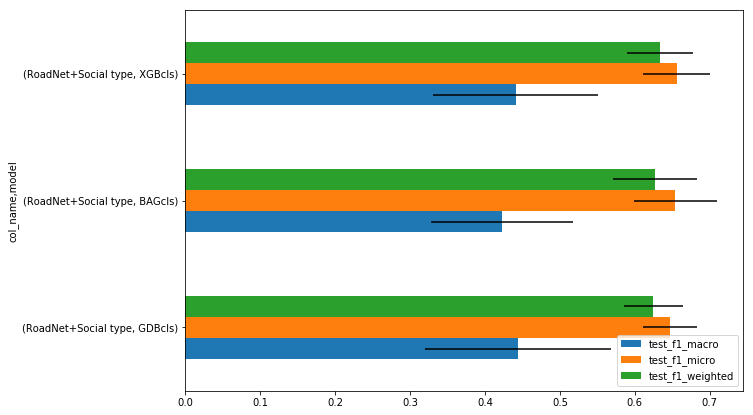

In [42]:
means_to_plot.sort_values(f1_type).plot(kind='barh', xerr=stds_to_plot, figsize=(10,7))

# Deprecated

# for the top 3 solution, see if period, feature selection and scale help
not really

In [186]:
cond1 = (all_run_res.model == 'XGBreg') & (all_run_res.col_name=='RoadNet+Segment NO_TOTAL')
cond2 = (all_run_res.model == 'XGBcls') & (all_run_res.col_name=='RoadNet+Segment TOTAL')
cond3 = (all_run_res.model == 'GDBcls') & (all_run_res.col_name=='RoadNet+Segment TOTAL')
cond4 = (all_run_res.model == 'ols') & (all_run_res.col_name=='RoadNet+Segment TOTAL')

slice_res = all_run_res[(cond1) | (cond2) | (cond3) | (cond4)].drop(['feature', 'total or by type', 'seed', 'kind', '# ftr remove', 
                  'train_acc', 'train_f1_macro', 'train_f1_micro', 'train_f1_weighted', 'train_mse',
                  'test_acc', 'test_mse'],axis=1).sort_values(['col_name', 'model'])

In [187]:
slice_res.groupby(['model', 'col_name', 'time period', 'feature_select', 'scale']).mean()

test_f1_macro  \
model  col_name                 time period feature_select scale                       
GDBcls RoadNet+Segment TOTAL    ~2014       None           max-cutoff       0.325695   
                                                           min-max          0.309382   
                                            mrmr           max-cutoff       0.316096   
                                                           min-max          0.312272   
                                            rfecv_linsvc   max-cutoff       0.279320   
                                                           min-max          0.275626   
                                ~2016       None           max-cutoff       0.310844   
                                                           min-max          0.301714   
                                            mrmr           max-cutoff       0.301570   
                                                           min-max          0.314554   
                                            rfecv_linsvc   max-cutoff       0.297601   
                                                           min-max          0.288727   
XGBcls RoadNet+Segment TOTAL    ~2014       None           max-cutoff       0.319983   
                                                           min-max          0.319983   
                                            mrmr           max-cutoff       0.319983   
                                                           min-max          0.319983   
                                            rfecv_linsvc   max-cutoff       0.292758   
                                                           min-max          0.280266   
                                ~2016       None           max-cutoff       0.272686   
                                                           min-max          0.272686   
                                            mrmr           max-cutoff       0.272686   
                                                           min-max          0.272686   
                                            rfecv_linsvc   max-cutoff       0.287765   
                                                           min-max          0.298830   
XGBreg RoadNet+Segment NO_TOTAL ~2014       None           max-cutoff       0.317581   
                                                           min-max          0.332753   
                                            mrmr           max-cutoff       0.332753   
                                                           min-max          0.332753   
                                            rfecv_linsvc   max-cutoff       0.268482   
                                                           min-max          0.254113   
                                ~2016       None           max-cutoff       0.293666   
                                                           min-max          0.287858   
                                            mrmr           max-cutoff       0.287858   
                                                           min-max          0.283026   
                                            rfecv_linsvc   max-cutoff       0.250856   
                                                           min-max          0.271155   
ols    RoadNet+Segment TOTAL    ~2014       None           max-cutoff       0.293364   
                                                           min-max          0.300342   
                                            mrmr           max-cutoff       0.300342   
                                                           min-max          0.300342   
                                            rfecv_linsvc   max-cutoff       0.258690   
                                                           min-max          0.281312   
                                ~2016       None           max-cutoff       0.306052   
                                                           min-max          0.314275   
                       

In [51]:
clean_res = all_run_res.drop(['feature', 'total or by type', 'time period', 'scale', 'feature_select',
                  'kind', '# ftr remove', '# ftr keep', 
                  'train_acc', 'train_f1_macro', 'train_f1_micro', 'train_f1_weighted', 'train_mse',
                  'test_acc', 'test_mse',
                  'seed',
                  'col_name', 'model'
                 ], axis=1)

In [53]:
means = clean_res.groupby('key').mean().sort_values('test_f1_weighted', ascending=False)

In [55]:
stds = clean_res.groupby('key').std()

In [56]:
%matplotlib inline

In [62]:
means_to_plot = means.head(10)
index_to_plot = means_to_plot.index

stds_to_plot = stds.loc[index_to_plot]
stds_to_plot

,test_f1_macro,test_f1_micro,test_f1_weighted
key,,,
RoadNet+Segment NO_TOTAL ~2014 XGBreg min-max mrmr,0.040526,0.079365,0.068269
RoadNet+Segment NO_TOTAL ~2014 XGBreg min-max None,0.040526,0.079365,0.068269
RoadNet+Segment NO_TOTAL ~2014 XGBreg max-cutoff mrmr,0.040526,0.079365,0.068269
RoadNet+Segment NO_TOTAL ~2014 XGBreg max-cutoff None,0.020002,0.055442,0.051565
RoadNet+Segment TOTAL ~2014 GDBcls max-cutoff None,0.056162,0.069873,0.066956
RoadNet+Segment NO_TOTAL ~2016 XGBcls min-max rfecv_linsvc,0.053360,0.080155,0.080876
RoadNet+Segment TOTAL ~2014 GDBcls max-cutoff mrmr,0.051958,0.052271,0.054188
RoadNet+Segment TOTAL ~2016 BAGcls max-cutoff mrmr,0.082135,0.076106,0.075219
RoadNet+Segment TOTAL ~2014 XGBcls min-max mrmr,0.028119,0.054023,0.059369


In [63]:
means_to_plot

,test_f1_macro,test_f1_micro,test_f1_weighted
key,,,
RoadNet+Segment NO_TOTAL ~2014 XGBreg min-max mrmr,0.332753,0.555556,0.532707
RoadNet+Segment NO_TOTAL ~2014 XGBreg min-max None,0.332753,0.555556,0.532707
RoadNet+Segment NO_TOTAL ~2014 XGBreg max-cutoff mrmr,0.332753,0.555556,0.532707
RoadNet+Segment NO_TOTAL ~2014 XGBreg max-cutoff None,0.317581,0.552381,0.532411
RoadNet+Segment TOTAL ~2014 GDBcls max-cutoff None,0.325695,0.549206,0.523662
RoadNet+Segment NO_TOTAL ~2016 XGBcls min-max rfecv_linsvc,0.321872,0.539683,0.520465
RoadNet+Segment TOTAL ~2014 GDBcls max-cutoff mrmr,0.316096,0.552381,0.518190
RoadNet+Segment TOTAL ~2016 BAGcls max-cutoff mrmr,0.330260,0.541270,0.516796
RoadNet+Segment TOTAL ~2014 XGBcls min-max mrmr,0.319983,0.527778,0.516758


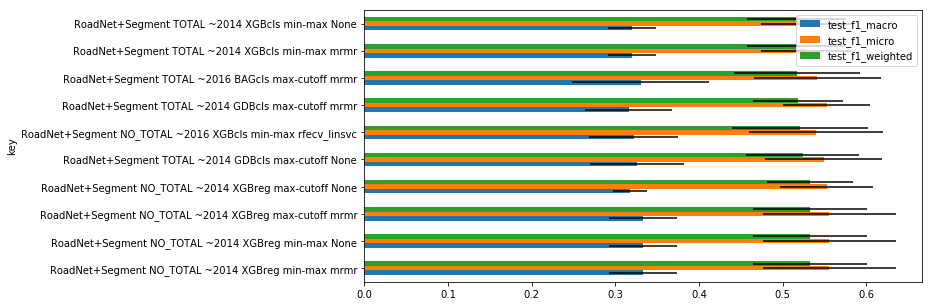

In [64]:
means_to_plot.plot(kind='barh', xerr=stds_to_plot, figsize=(10,5))

In [33]:
clean_res[clean_res.key.isin(index_to_plot[:1])]

,test_f1_macro,test_f1_micro,test_f1_weighted,key
707,0.312994,0.619048,0.590639,RoadNet+Segment TOTAL ~2014 GDBcls max-cutoff ...
1723,0.329147,0.476190,0.458477,RoadNet+Segment TOTAL ~2014 GDBcls max-cutoff ...
2744,0.316695,0.571429,0.551029,RoadNet+Segment TOTAL ~2014 GDBcls max-cutoff ...
3774,0.290438,0.507937,0.476017,RoadNet+Segment TOTAL ~2014 GDBcls max-cutoff ...
4787,0.439818,0.650794,0.616350,RoadNet+Segment TOTAL ~2014 GDBcls max-cutoff ...
5808,0.330880,0.571429,0.537587,RoadNet+Segment TOTAL ~2014 GDBcls max-cutoff ...
6832,0.264004,0.507937,0.455709,RoadNet+Segment TOTAL ~2014 GDBcls max-cutoff ...
7853,0.296735,0.539683,0.526903,RoadNet+Segment TOTAL ~2014 GDBcls max-cutoff ...
8869,0.282423,0.555556,0.490979,RoadNet+Segment TOTAL ~2014 GDBcls max-cutoff ...
9891,0.321478,0.555556,0.518747,RoadNet+Segment TOTAL ~2014 GDBcls max-cutoff ...
